# Clustering 3k PBMCs following a Seurat Tutorial

This started out (July 2017) with a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) clustering tutorial ([link](http://satijalab.org/seurat/pbmc3k_tutorial.html)), which we gratefully acknowledge. In the meanwhile, we have added and removed several pieces.

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [12]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from scipy import sparse, io
from collections import Counter
import os.path
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import pickle
import os
import datetime
import hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import time
# import utils
import seurat_utils
import hyperopt_utils
plt.ion()
plt.show()
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()


In [13]:
%load_ext autoreload
import importlib
importlib.reload(seurat_utils)
importlib.reload(hyperopt_utils)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.3.3 anndata==0.6.13 numpy==1.14.2 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


<module 'hyperopt_utils' from '/home/mada/ml/single-cell-sota/seurat/hyperopt_utils.py'>

## Generic method for running bayesian hyperparm optimisation for all datasets

In [3]:

def runSeurat(filename, space, max_evals = 2):
    # Define function to optimise
    def evaluateSeurat(args):
        args['cluster_n_neighbors'] = int(args['cluster_n_neighbors'])
        args['cluster_n_pcs'] = int(args['cluster_n_pcs'])

        if args['bpreprocess_min_genes'] == False:
            args['preprocess_min_genes'] = -1
        if args['bpreprocess_min_cells'] == False:
            args['preprocess_min_cells'] = -1
        if args['bpreprocess_teta_total_features'] == False:
            args['preprocess_teta_total_features'] = -1
        if args['bpreprocess_filter_min_mean'] == False:
            args['preprocess_filter_min_mean'] = -1
        if args['bpreprocess_filter_min_disp'] == False:
            args['preprocess_filter_min_disp'] = -1

        if args['preprocess_teta_total_features'] is not None:
            args['preprocess_teta_total_features'] = int(args['preprocess_teta_total_features'])
        try:
            resultDict = seurat_utils.run(args)
        except:
            return { 'status' : hyperopt.STATUS_FAIL}

        print(f'>> Result: {resultDict["randIndex"]}')
        ret = {
            'loss' : -resultDict['randIndex']
            ,'status' : STATUS_OK
            ,'eval_time' : time.time()        
        }
        return ret

    trials = hyperopt_utils.getTrials(filename ,restart = False )
    evals_per_epoch = 10
    for e in range(len(trials), max_evals, evals_per_epoch):
        best = fmin(evaluateSeurat
                    ,space
                    ,algo=tpe.suggest 
                    ,max_evals= e + evals_per_epoch
                    ,trials=trials)
        print('Index ', e)
        pickle.dump(trials, open(filename, 'wb'))
    return trials


# BrainCIDR

Run it once with all default parameters to get the parameter range

... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 2854 genes that are detected in less than 3 cells


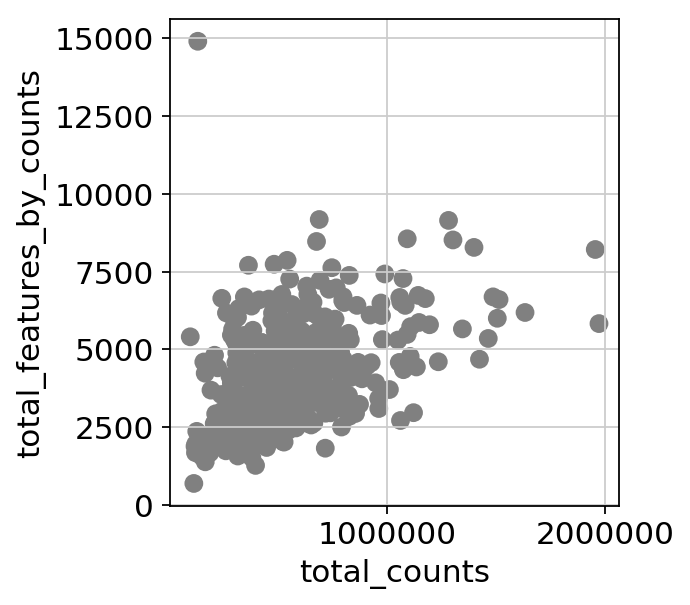

Filtering Counter({False: 13027, True: 6204})


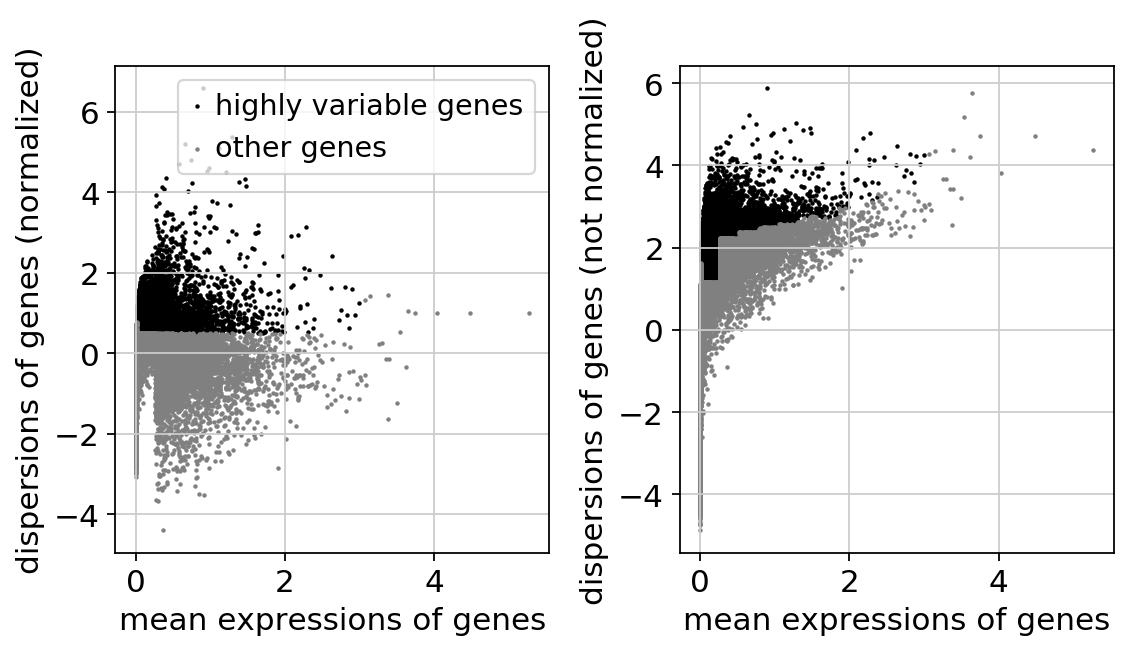

Keeping 6204 genes
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:12.57)


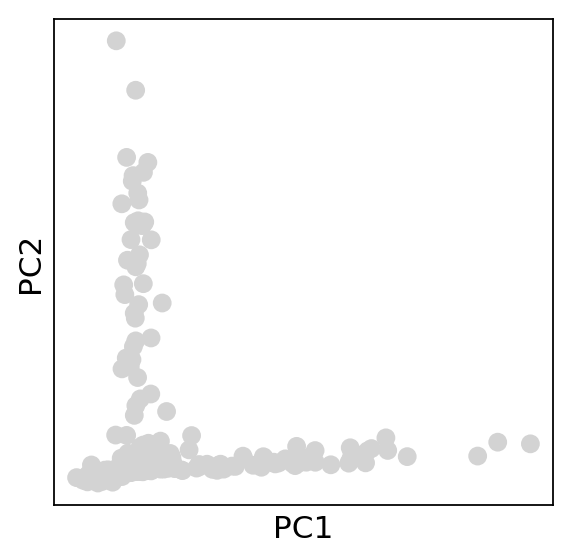

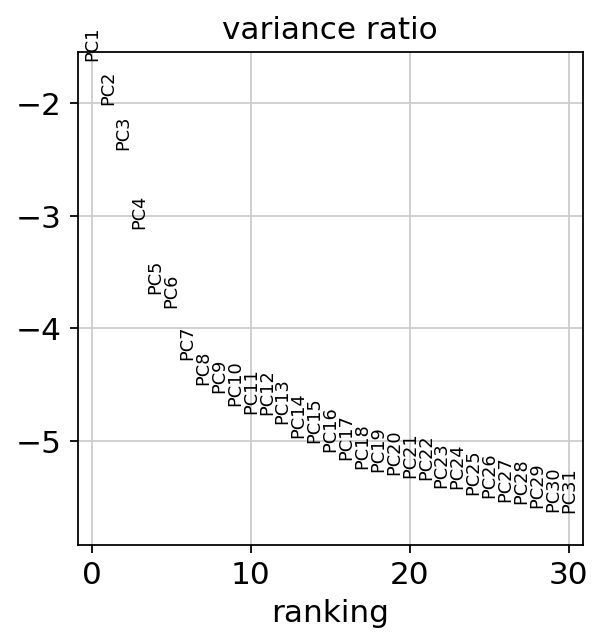

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.13) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.89) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5341774376930473


{'cluster_n_neighbors': 10,
 'cluster_n_pcs': 40,
 'cluster_plot_pca': True,
 'evaluate_plot_results': True,
 'load_inputDataset': 'brainCIDR',
 'preprocess_filter_max_mean': 3,
 'preprocess_filter_min_disp': 0.5,
 'preprocess_filter_min_mean': 0.0125,
 'preprocess_min_cells': 3,
 'preprocess_min_genes': 200,
 'preprocess_normalize_per_cell': True,
 'preprocess_regress_out': 'total_counts',
 'preprocess_scale': 10,
 'preprocess_teta_total_features': 8000,
 'randIndex': 0.5341774376930473}

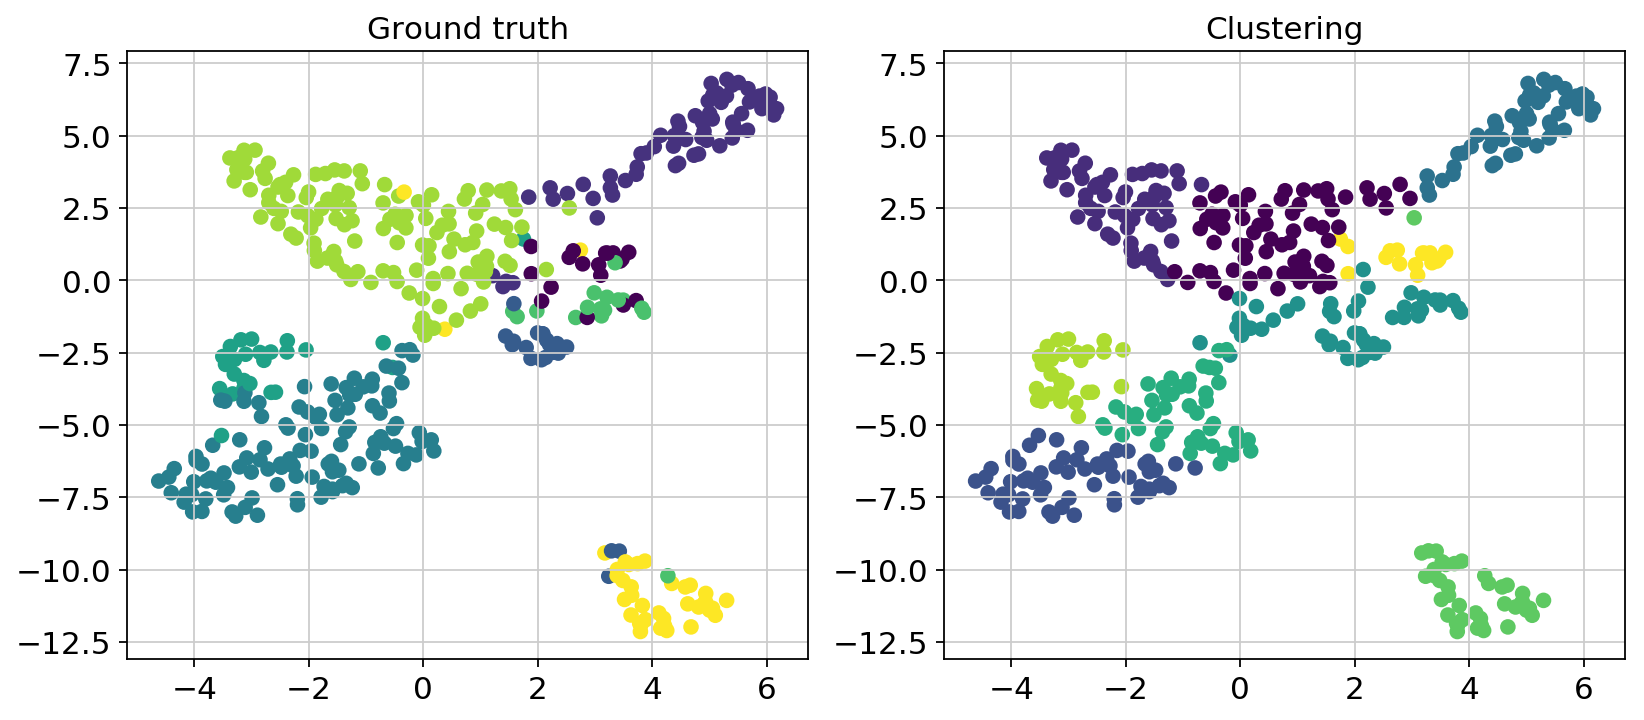

In [9]:
params = {}
params['load_inputDataset'] = 'brainCIDR'
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = 8000
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']='total_counts'
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = True

params['evaluate_plot_results'] = True
seurat_utils.run(params)

### Hyperopt input

In [14]:

space = {
    'load_inputDataset' : 'brainCIDR'
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 5000, 15000, 1000)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}

filename = 'brainCIDR_trials.pkl'


'brainCIDR_trials.pkl'

In [15]:
trials=hyperopt_utils.getTrials(filename ,restart = False )

Reload trials size :80


In [ ]:

trials = runSeurat(filename, space, max_evals = 200);

Creating new trials...
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use


/home/mada/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.40)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.57) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.4313024719946615
>> Result: 0.4313024719946615
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 5755 genes that are detected in less than 8.0 cells
regressing out ['total

/home/mada/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1000: RuntimeWarning: invalid value encountered in true_divide
  X /= scale
/home/mada/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:788: RuntimeWarning: invalid value encountered in greater
  if max_value is not None: X[X > max_value] = max_value


... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 2854 genes that are detected in less than 3.0 cells


/home/mada/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:38.96)
computing neighbors
    using 'X_pca' with n_pcs = 24
    finished (0:00:00.14) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.87) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6683707253061745
>> Result: 0.6683707253061745
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 7792 genes that are detected in less than 16.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:29.53)
computing neighbors
  

/home/mada/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:28.43)
computing neighbors
    using 'X_pca' with n_pcs = 42
    finished (0:00:00.18) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.05) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.03) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.4348108411063758
>> Result: 0.4348108411063758
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
computing neighbors
    using 'X_pca' with n_pcs = 49
    finished (0:00:00.11) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
compu

/home/mada/anaconda3/lib/python3.6/site-packages/scanpy/neighbors/umap/umap_.py:864: RuntimeWarning: divide by zero encountered in true_divide
  D = scipy.sparse.spdiags(1.0 / np.sqrt(diag_data), 0, graph.shape[0],


Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 5755 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:32.76)
computing neighbors
    using 'X_pca' with n_pcs = 48
    finished (0:00:00.16) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.02) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6946062684491263
>> Result: 0.6946062684491263
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 6962 genes that are detected in less than 12.0 cells
regressing out ['tota

/home/mada/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 5334 genes that are detected in less than 7.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:33.32)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.16) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.00) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6389053704609434
>> Result: 0.6389053704609434
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
regressing out ['total

regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:30.57)
computing neighbors
    using 'X_pca' with n_pcs = 27
    finished (0:00:00.16) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.02) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.8281324582168761
>> Result: 0.8281324582168761
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 6433 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:08.58)
computing neighbors
   

/home/mada/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1000: RuntimeWarning: invalid value encountered in true_divide
  X /= scale
/home/mada/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:788: RuntimeWarning: invalid value encountered in greater
  if max_value is not None: X[X > max_value] = max_value


computing neighbors
    using 'X_pca' with n_pcs = 26
    finished (0:00:00.15) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.88) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5158472157452478
>> Result: 0.5158472157452478
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 7792 genes that are detected in less than 16.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.75)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.16) --> added to `.uns['neighbors']`
    'distances', weighted adja

    finished (0:00:29.16)
computing neighbors
    using 'X_pca' with n_pcs = 39
    finished (0:00:00.15) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.26) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.8092471430108296
>> Result: 0.8092471430108296
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 8343 genes that are detected in less than 19.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:28.40)
computing neighbors
    using 'X_pca' with n_pcs = 46
    finished (0:00:00.15) --> added to `.uns['neighbors']`
    

/home/mada/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 3625 genes that are detected in less than 4.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:09.03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.16) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.13) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5927219680298792
>> Result: 0.5927219680298792
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 8495 genes that are detected in less than 20.0 cells
computing neighbors
 

Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 8495 genes that are detected in less than 20.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:29.76)
computing neighbors
    using 'X_pca' with n_pcs = 34
    finished (0:00:00.16) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:02.54) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.10) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7984450532619163
>> Result: 0.7984450532619163
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 7388 genes that are detected in less than 14.0 cells
regressing out ['tot

In [16]:
df = hyperopt_utils.getResultsAsDf(trials, space)
df.head()

,load_inputDataset,bpreprocess_min_genes,preprocess_min_genes,bpreprocess_min_cells,preprocess_min_cells,bpreprocess_teta_total_features,preprocess_teta_total_features,preprocess_normalize_per_cell,bpreprocess_filter_min_mean,preprocess_filter_min_mean,...,preprocess_filter_min_disp,preprocess_regress_out,preprocess_scale,cluster_n_neighbors,cluster_n_pcs,cluster_plot_pca,preprocess_plot_preprocessing,evaluate_plot_results,preprocess_verbosity,result
0,brainCIDR,False,430.0,False,3.0,False,11000.0,False,False,0.193999,...,0.225866,total_counts,20,12.0,40.0,False,False,False,0,NaN
1,brainCIDR,True,140.0,False,3.0,True,14000.0,True,True,0.032831,...,0.328177,total_counts,20,5.0,30.0,False,False,False,0,-0.431302
2,brainCIDR,False,420.0,True,8.0,False,14000.0,False,False,0.100963,...,0.087037,total_counts,15,19.0,22.0,False,False,False,0,-0.774876
3,brainCIDR,False,240.0,True,8.0,True,14000.0,False,False,0.035382,...,0.754317,total_counts,20,17.0,28.0,False,False,False,0,-0.551759
4,brainCIDR,False,250.0,False,15.0,False,13000.0,False,True,0.197635,...,0.737586,none,15,5.0,22.0,False,False,False,0,-0.431472


Best result: 

In [18]:
df.sort_values(by='result').head()

,load_inputDataset,bpreprocess_min_genes,preprocess_min_genes,bpreprocess_min_cells,preprocess_min_cells,bpreprocess_teta_total_features,preprocess_teta_total_features,preprocess_normalize_per_cell,bpreprocess_filter_min_mean,preprocess_filter_min_mean,...,preprocess_filter_min_disp,preprocess_regress_out,preprocess_scale,cluster_n_neighbors,cluster_n_pcs,cluster_plot_pca,preprocess_plot_preprocessing,evaluate_plot_results,preprocess_verbosity,result
41,brainCIDR,False,330.0,True,11.0,False,8000.0,False,False,0.123971,...,0.455819,total_counts,10,16.0,27.0,False,False,False,0,-0.828132
75,brainCIDR,True,180.0,True,12.0,False,12000.0,True,False,0.167542,...,0.377576,total_counts,5,16.0,41.0,False,False,False,0,-0.816938
55,brainCIDR,True,270.0,True,20.0,False,9000.0,True,False,0.170655,...,0.506361,total_counts,20,17.0,39.0,False,False,False,0,-0.809247
69,brainCIDR,True,260.0,True,20.0,False,10000.0,True,False,0.141818,...,0.460189,total_counts,20,17.0,41.0,False,False,False,0,-0.807504
56,brainCIDR,True,200.0,True,19.0,False,10000.0,True,False,0.191858,...,0.349847,total_counts,20,17.0,46.0,False,False,False,0,-0.802339


In [20]:
df.to_pickle('brainCIDR.pkl')

# PancreaticIsletCIDR

Run it once with all default parameters to get the parameter range

... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 62604 genes that are detected in less than 3 cells


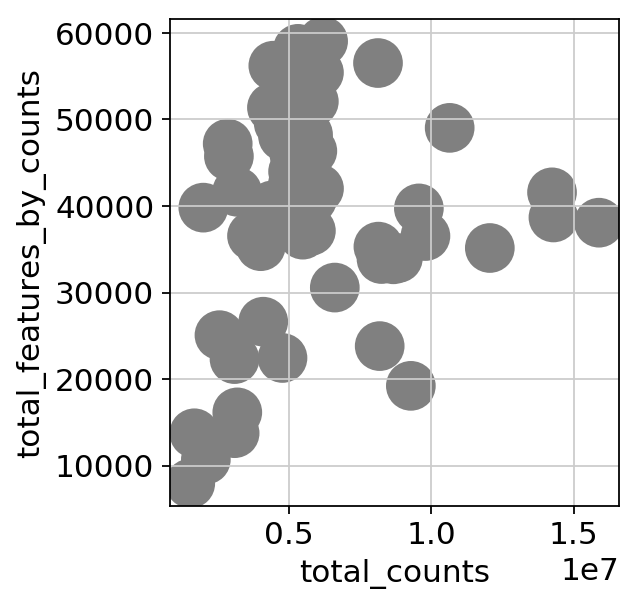

Filtering Counter({False: 82947, True: 34702})


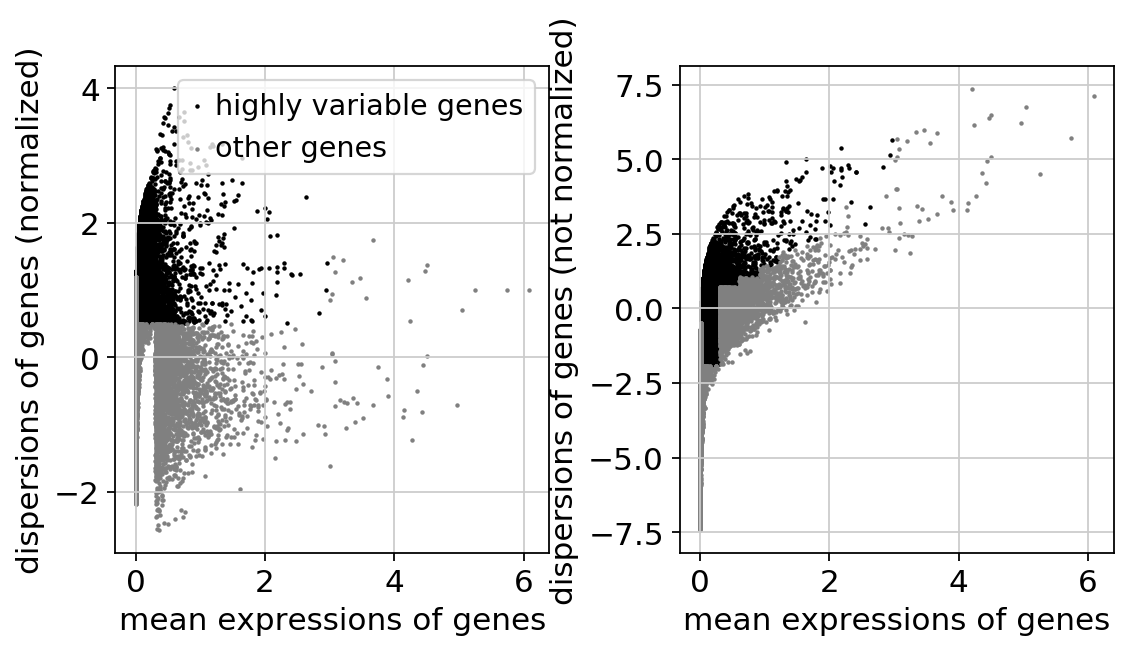

Keeping 34702 genes
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:01:05.89)


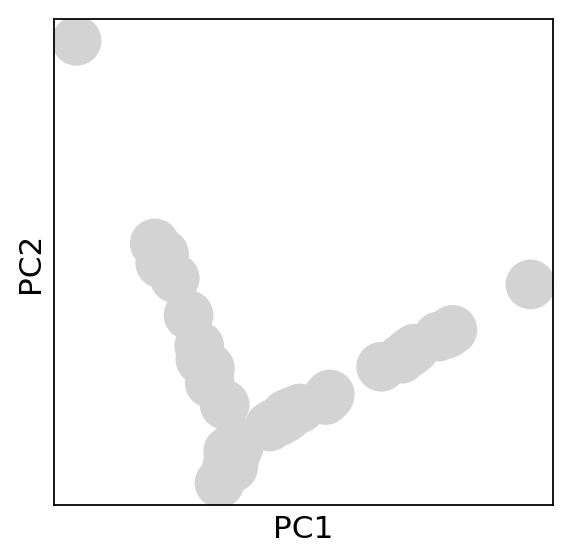

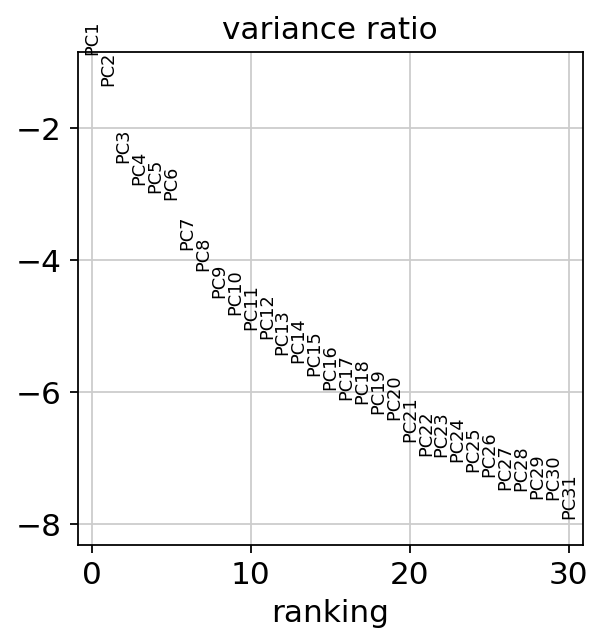

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.01) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.12) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.8272327964860908


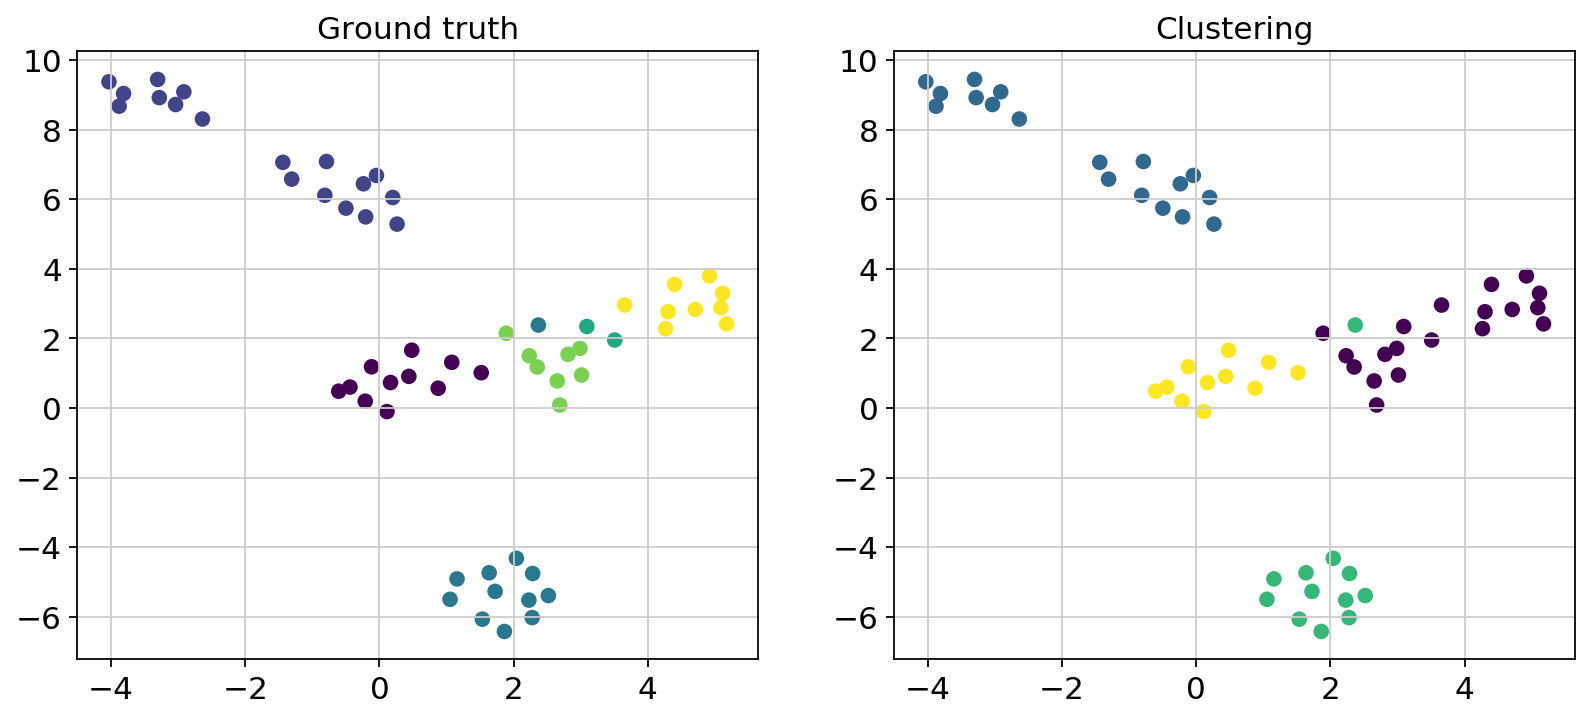

In [28]:
params = {}
params['load_inputDataset'] = 'pancreaticIsletCIDR'
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = -1
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']='total_counts'
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = True

params['evaluate_plot_results'] = True
seurat_utils.run(params);

### Hyperopt input

In [29]:

space = {
    'load_inputDataset' : 'pancreaticIsletCIDR'
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 45000, 60000, 2000)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}

filename = 'pancreaticIsletCIDR_trials.pkl'  

In [4]:
# trials=hyperopt_utils.getTrials(filename ,restart = False )

Reload trials size :20


In [ ]:

trials = runSeurat(filename, space, max_evals = 200);

Creating new trials...
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 103850 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:11.51)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.13) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7253788400416434
>> Result: 0.7253788400416434
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreat

/home/mada/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1000: RuntimeWarning: invalid value encountered in true_divide
  X /= scale
/home/mada/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:788: RuntimeWarning: invalid value encountered in greater
  if max_value is not None: X[X > max_value] = max_value


computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.58) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7535354435526543
>> Result: 0.7535354435526543
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.28)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted ad

/home/mada/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.01) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.17) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.781689396342108
>> Result: 0.781689396342108
Index  0
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 91467 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use


In [ ]:
df = hyperopt_utils.getResultsAsDf(trials, space)
df.head()

Best result: 

In [ ]:
df['result'].min()

In [ ]:
df.to_pickle('pancreaticIsletCIDR.pkl')

# Deng

Run it once with all default parameters to get the parameter range

... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 2854 genes that are detected in less than 3 cells


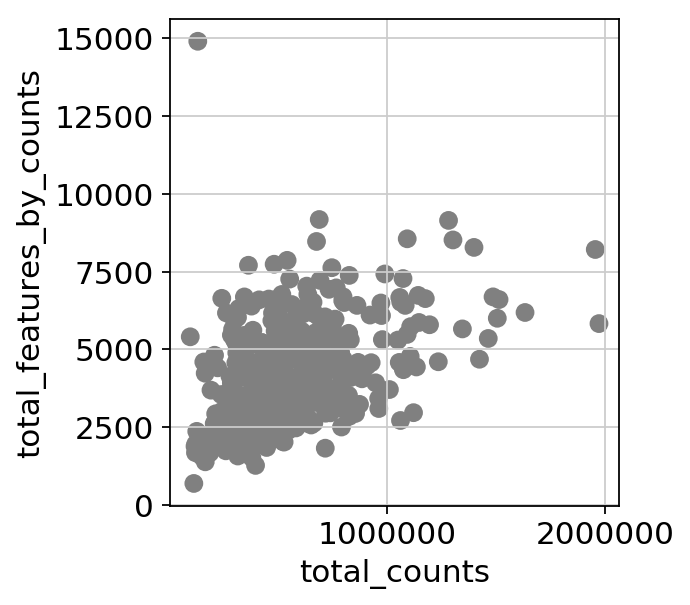

Filtering Counter({False: 13027, True: 6204})


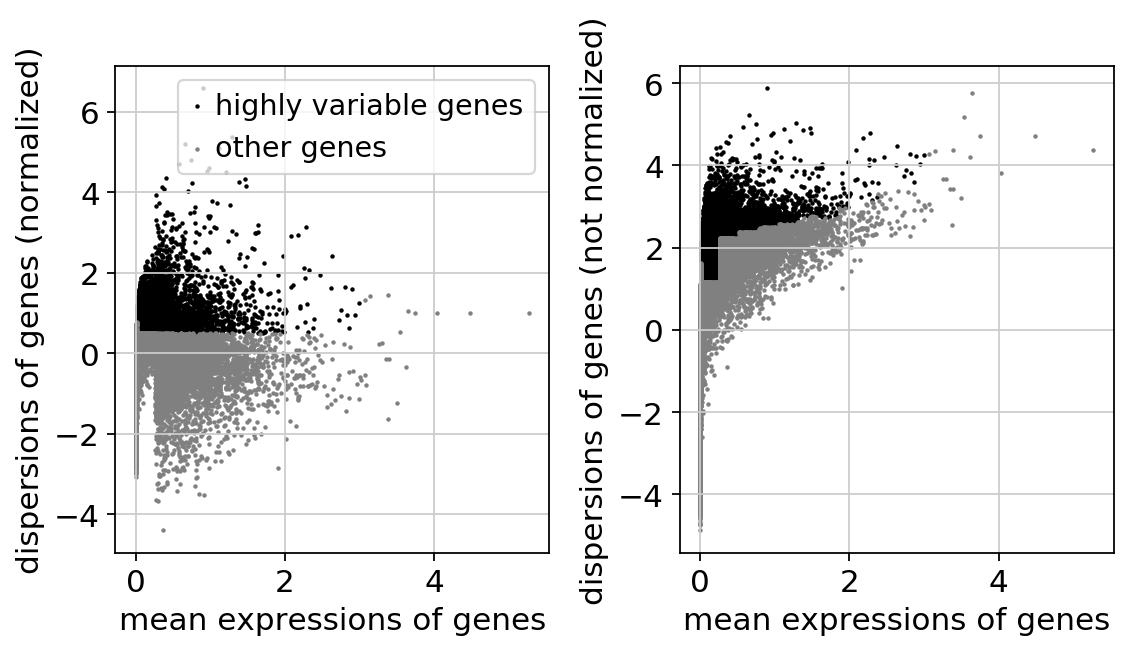

Keeping 6204 genes
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:12.57)


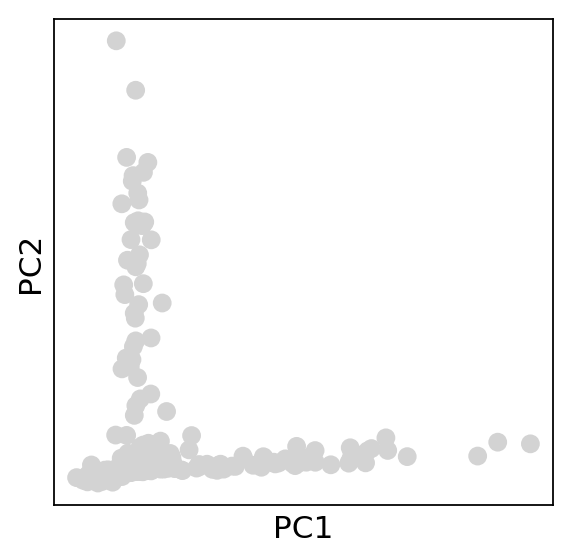

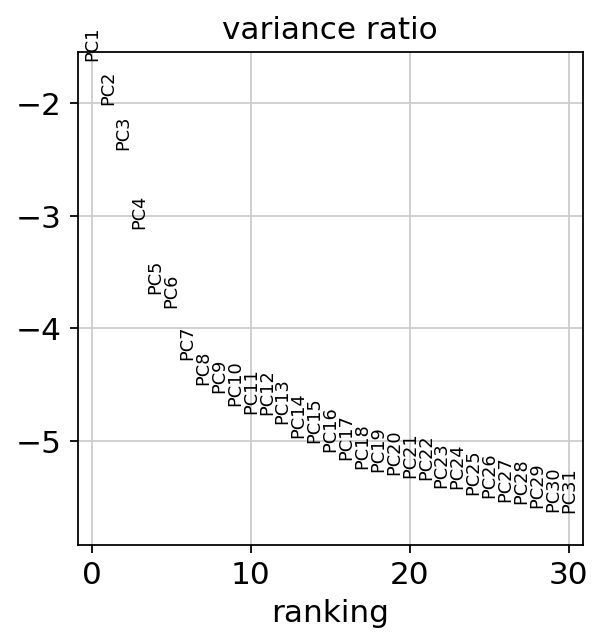

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.13) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.89) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5341774376930473


{'cluster_n_neighbors': 10,
 'cluster_n_pcs': 40,
 'cluster_plot_pca': True,
 'evaluate_plot_results': True,
 'load_inputDataset': 'brainCIDR',
 'preprocess_filter_max_mean': 3,
 'preprocess_filter_min_disp': 0.5,
 'preprocess_filter_min_mean': 0.0125,
 'preprocess_min_cells': 3,
 'preprocess_min_genes': 200,
 'preprocess_normalize_per_cell': True,
 'preprocess_regress_out': 'total_counts',
 'preprocess_scale': 10,
 'preprocess_teta_total_features': 8000,
 'randIndex': 0.5341774376930473}

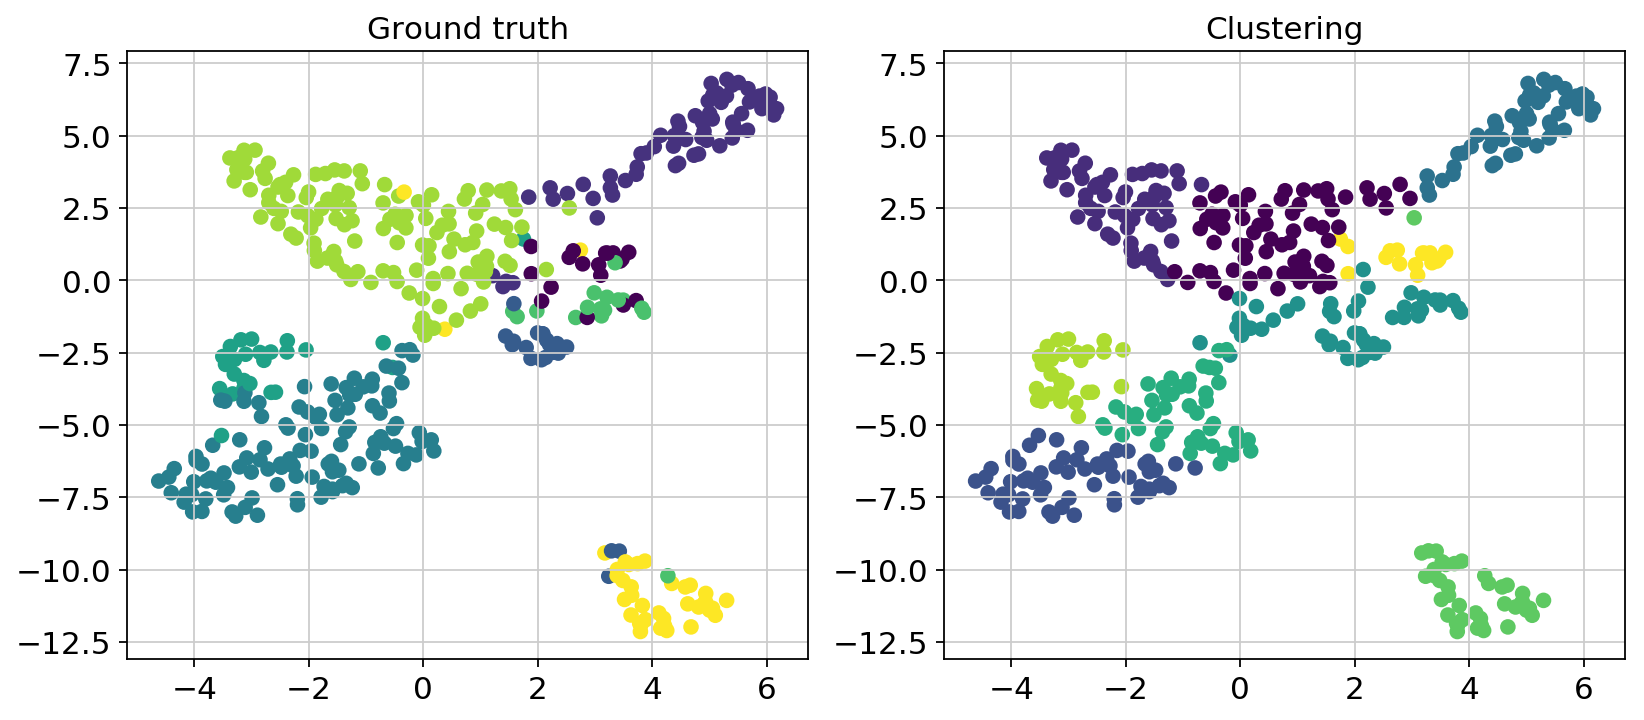

In [9]:
params = {}
params['load_inputDataset'] = 'deng'
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = -1
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']=None
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = False

params['evaluate_plot_results'] = True
seurat_utils.run(params)

### Hyperopt input

In [10]:

space = {
    'load_inputDataset' : 'pancreaticIsletCIDR'
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 10000, 15000, 500)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}

filename = 'deng_trials.pkl'  

In [4]:
# trials=hyperopt_utils.getTrials(filename ,restart = False )

Reload trials size :20


In [ ]:

trials = runSeurat(filename, space, max_evals = 500);

Creating new trials...
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use


/home/mada/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.40)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.57) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.4313024719946615
>> Result: 0.4313024719946615
... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 5755 genes that are detected in less than 8.0 cells
regressing out ['total

In [ ]:
df = hyperopt_utils.getResultsAsDf(trials, space)
df.head()

Best result: 

In [ ]:
df['result'].min()

In [ ]:
df.to_pickle('deng.pkl')